In [38]:
import os
import shutil
import segformer_b0 as seg
import cv2
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
%matplotlib inline

left_dir = '/mnt/c/Users/kbh11/OneDrive/Documents/Tank Challenge/capture_images/L'
right_dir = '/mnt/c/Users/kbh11/OneDrive/Documents/Tank Challenge/capture_images/R'
result_dir = "results"

seg_model, image_processor = seg.init_model()

class_mapping = {
    0 :'void',
    1 :'dirt',
    # 2 :'sand',
    2 :'grass' ,
    3 :'tree' ,
    4 :'obstacle' ,
    5 :'water' ,
    6 :'sky' ,
    7 :'vehicle' ,
    8 :'person' ,
    9 :'hard_surface',
    10 : 'gravel',
    11 :'vegetation' ,
    # 13 :'mulch',
    12 :'rock',
    13 :'cannon',
}

class_to_rgb_map = {
    0 : (0, 0, 0),
    1 : (108, 64, 20),
    # 2 : (255, 229, 204),
    2 : (0, 102, 0),
    3 : (0, 255, 0),
    4 : (0, 153, 153),
    5 : (0, 128, 255),
    6 : (0, 0, 255),
    7 : (255, 255, 0),
    8 : (255, 0, 127),
    9 : (64, 64, 64),
    10 : (100, 110, 50),
    11 : (183, 255, 0),
    # 13 : (153, 76, 0),
    12 : (160, 160, 160),
    13 : (140,120,240)
}

/home/kim/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([14, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


😊 Segformer_b0 has been Initialized!!💙


In [39]:
def get_item_dir(from_dir):
    items = sorted(os.listdir(from_dir))
    item = items[-1]
    item_dir = os.path.join(from_dir, item)
    return items, item_dir

In [ ]:
def get_vehicle_distance(seg_model, image_processor):
    left_items, left_item_dir = get_item_dir(left_dir)
    right_items, right_item_dir = get_item_dir(right_dir)

    left_prediction = seg.predict_segmentation(left_item_dir, seg_model, image_processor)
    right_prediction = seg.predict_segmentation(right_item_dir, seg_model, image_processor)

    img_left = cv2.imread(left_item_dir, cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(right_item_dir, cv2.IMREAD_GRAYSCALE)

    seg_mask_left_resized = cv2.resize(left_prediction.astype(np.uint8), (512, 512), interpolation=cv2.INTER_NEAREST)
    seg_mask_right_resized = cv2.resize(right_prediction.astype(np.uint8), (512, 512), interpolation=cv2.INTER_NEAREST)

    # 3. 스테레오 매칭 설정 (간단한 SGBM 설정)
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=64,
        blockSize=5,
        P1=8 * 1 * 5**2,
        P2=32 * 1 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM
    )

    # 4. 시차 맵 계산
    disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

    # 시차 맵 정규화 (시각화용)
    # disparity_visual = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # 5. 깊이 맵 계산
    focal_length = 240  # 초점 거리 (픽셀 단위, 예시 값)
    baseline = 1         # 기본선 거리 (미터 단위, 예시 값)
    depth_map = np.zeros_like(disparity)
    valid_disparity = disparity > 0.1  # 유효한 시차만 선택
    depth_map[valid_disparity] = (focal_length * baseline) / disparity[valid_disparity]

    # 깊이 맵 정규화 (시각화용)
    # depth_map_visual = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # 6. 특정 클래스(예: 클래스 1)에 대한 깊이 맵 추출
    target_class = 7
    mask_left = (seg_mask_left_resized == target_class).astype(np.uint8)
    mask_right = (seg_mask_right_resized == target_class).astype(np.uint8)
    combined_mask = cv2.bitwise_and(mask_left, mask_right)  # 좌/우 공통 영역
    masked_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=combined_mask)

    distance = np.mean(masked_depth_map[masked_depth_map != 0])

    return distance

In [ ]:
def get_depth_and_class(seg_model, image_processor):
    left_items, left_item_dir = get_item_dir(left_dir)
    right_items, right_item_dir = get_item_dir(right_dir)

    left_prediction = seg.predict_segmentation(left_item_dir, seg_model, image_processor)
    right_prediction = seg.predict_segmentation(right_item_dir, seg_model, image_processor)

    img_left = cv2.imread(left_item_dir, cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(right_item_dir, cv2.IMREAD_GRAYSCALE)

    img_left_resized = cv2.resize(img_left, (128, 128), interpolation=cv2.INTER_NEAREST)
    img_right_resized = cv2.resize(img_right, (128, 128), interpolation=cv2.INTER_NEAREST)

    # 3. 스테레오 매칭 설정 (간단한 SGBM 설정)
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16,
        blockSize=5,
        P1=8 * 1 * 5**2,
        P2=32 * 1 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM
    )

    # 4. 시차 맵 계산
    disparity = stereo.compute(img_left_resized, img_right_resized).astype(np.float32) / 16.0

    # 5. 깊이 맵 계산
    focal_length = 240  # 초점 거리 (픽셀 단위, 예시 값)
    baseline = 1         # 기본선 거리 (미터 단위, 예시 값)
    depth_map = np.zeros_like(disparity)
    valid_disparity = disparity > 0.1  # 유효한 시차만 선택
    depth_map[valid_disparity] = (focal_length * baseline) / disparity[valid_disparity]

    classes = class_mapping.keys()
    seg_map = np.zeros((128, 128))
    init_depth_map = np.zeros((128, 128))
    for num in classes:
        mask_left = (left_prediction == num).astype(np.uint8)
        mask_right = (right_prediction == num).astype(np.uint8)
        combined_mask = cv2.bitwise_and(mask_left, mask_right)  # 좌/우 공통 영역
        init_depth_map[combined_mask != 0] = depth_map[combined_mask != 0]
        seg_map[combined_mask != 0] = left_prediction[combined_mask != 0]
    init_depth_map[init_depth_map > 200 ] = 0
    disparity = 16
    shifted_mask = np.roll(seg_map, shift=disparity, axis=1)
    if disparity > 0:
        shifted_mask[:, :disparity] = 0  # 왼쪽 공백을 0으로 채움
    elif disparity < 0:
        shifted_mask[:, disparity:] = 0  # 오른쪽 공백을 0으로 채움
    two_chan = np.dstack([init_depth_map, shifted_mask])

    return two_chan

In [51]:
pixel_coords = np.where(combined_mask == 1)
pixel_coords = np.column_stack((pixel_coords[0], pixel_coords[1]))

type(pixel_coords)
len(pixel_coords) == 0

True

In [52]:
db = DBSCAN(eps=5.0, min_samples=64, metric='euclidean').fit(pixel_coords)
labels = db.labels_

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by DBSCAN.

In [ ]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # 노이즈(-1) 제외 클러스터 수
print(f"식별된 자동차 수: {n_clusters}")

식별된 자동차 수: 2


In [ ]:
# 각 클러스터의 픽셀 수 출력
for cluster_id in range(n_clusters):
    cluster_pixels = pixel_coords[labels == cluster_id]
    print(f"자동차 {cluster_id + 1}: {len(cluster_pixels)} 픽셀")

자동차 1: 560 픽셀
자동차 2: 1472 픽셀


In [ ]:
# 4. (선택) 클러스터링 결과 시각화
output_mask = np.zeros_like(combined_mask, dtype=np.uint8)
for cluster_id in range(n_clusters):
    cluster_pixels = pixel_coords[labels == cluster_id]
    for x, y in cluster_pixels:
        output_mask[x, y] = masked_depth_map[x, y]
    distance = output_mask[output_mask != 0].mean()
    print(f"자동차 {cluster_id + 1}: {len(cluster_pixels)} 픽셀")
    print(f"자동차 {cluster_id + 1}: {distance} 거리")

자동차 1: 560 픽셀
자동차 1: 131.7847866419295 거리
자동차 2: 1472 픽셀
자동차 2: 93.5288844621514 거리


In [ ]:
# 결과 이미지 저장
cv2.imwrite("clustered_cars.png", output_mask)

True

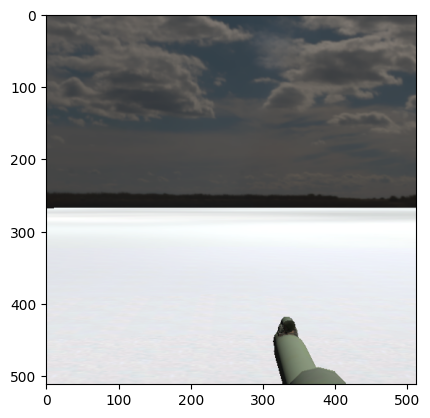

In [ ]:
plt.imshow(cv2.imread(left_item_dir, cv2.IMREAD_COLOR_RGB))

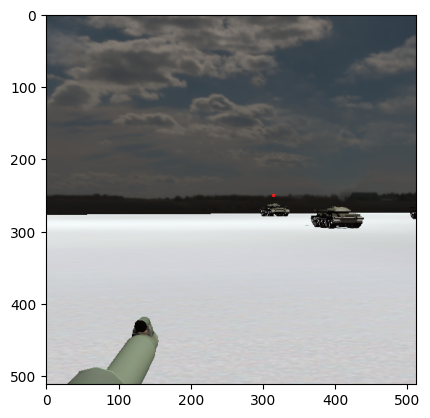

In [ ]:
plt.imshow(cv2.imread(right_item_dir, cv2.IMREAD_COLOR_RGB))

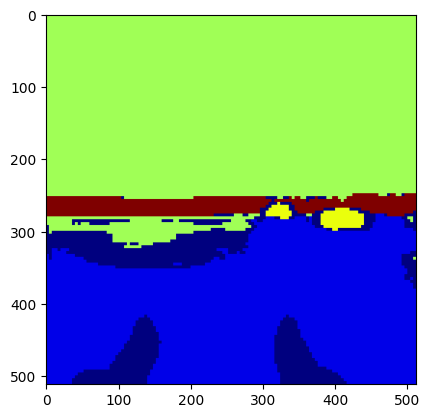

In [ ]:
plt.imshow(seg_map, cmap='jet')

In [ ]:
cx, cy = 256, 256

# 3. 3D 좌표 계산
height, width = depth_map.shape
x, _ = np.meshgrid(np.arange(width), np.arange(height))
x = x.astype(np.float32)

Z = depth_map
Z[depth_map > 150] = 0
Z[seg_map == 0] = 0
X = (x - cx) * Z / focal_length
X[seg_map == 0] = 0


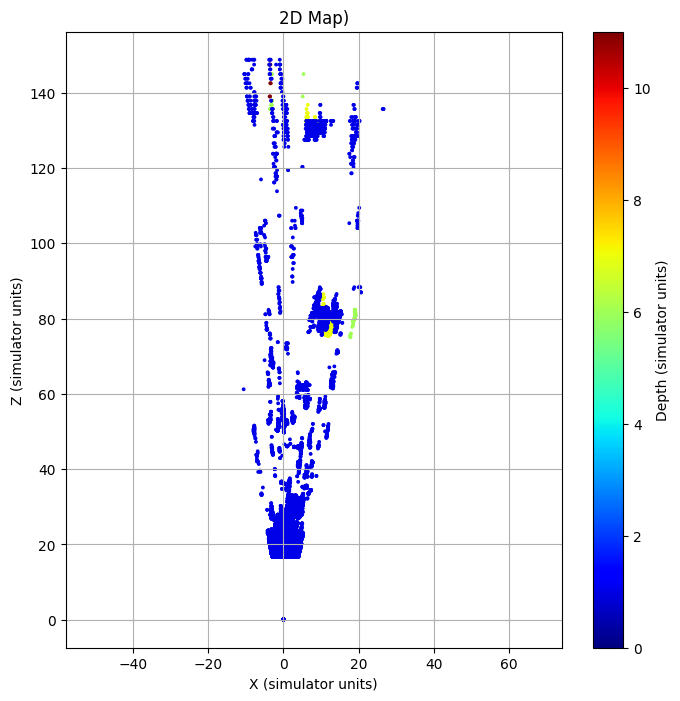

In [ ]:
# 5. 2D 지도 시각화 (XY 평면)
plt.figure(figsize=(8, 8))
sc = plt.scatter(X.ravel(), Z.ravel(), c=seg_map, cmap='jet', s=3, alpha=1)
plt.colorbar(sc, label='Depth (simulator units)')
plt.xlabel('X (simulator units)')
plt.ylabel('Z (simulator units)')
plt.title(f'2D Map)')
plt.grid(True)
plt.axis('equal')  # X, Y 비율 동일하게
plt.show()
# plt.savefig('2d_map_class_1.png')
plt.close()

In [ ]:

for item in left_items[:-1]:
    os.remove(os.path.join(left_dir, item))
for item in right_items[:-1]:
    os.remove(os.path.join(right_dir, item))